# 0. Imports

In [1]:
import os
import sys
import shutil
import xarray as xr
import hydroStats
import array
import random
import numpy as np
import csv
import geopandas as gpd
from shapely.geometry import Point

import datetime
import pandas as pd
from deap import algorithms
from deap import base
from deap import benchmarks
from deap import creator
from deap import tools
from osgeo import gdal
import pandas
import cftime
import multiprocessing
import time
from configparser import ConfigParser
import glob
from subprocess import Popen, PIPE
import matplotlib.pyplot as plt
import ast

from sys import platform
import pickle
import stat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
## Set global parameter
global gen
gen = 0
WarmupDays = 0
n_station = 2 
frequen = 'd'


# 1. Context data

In [2]:
xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/regional_parameters/regionalized_fraclandcover.nc')

<xarray.Dataset> Size: 710MB
Dimensions:          (time: 51, lat: 456, lon: 636)
Coordinates:
  * time             (time) datetime64[ns] 408B 1960-01-01 ... 2010-01-01
  * lat              (lat) float64 4kB 71.96 71.88 71.79 ... 34.21 34.13 34.04
  * lon              (lon) float64 5kB -11.96 -11.87 -11.79 ... 40.88 40.96
Data variables:
    fracforest       (time, lat, lon) float64 118MB ...
    fracgrassland    (time, lat, lon) float64 118MB ...
    fracirrNonPaddy  (time, lat, lon) float64 118MB ...
    fracirrPaddy     (time, lat, lon) float64 118MB ...
    fracsealed       (time, lat, lon) float64 118MB ...
    fracwater        (time, lat, lon) float64 118MB ...

In [3]:
# xr_sim = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/best_run_calibration/discharge_daily.nc')
xr_sim = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/europe_5min/discharge_daily.nc')

In [4]:
xr_obs = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope3 - Kopie.nc')

In [13]:
your_path = '/work/ch0636/g300128/Hydrologie_Calibration/Calibration/runs_calibration_net_cdf/'  # The directory where there are all the simulations
# Remplacez 'chemin_vers_votre_fichier.shp' par le chemin réel vers votre fichier shapefile
chemin_fichier_shapefile = '/work/ch0636/g300128/Hydrologie_Calibration/data/hybas/hybas_eu_lev04_v1c.shp'

xr_obs_gauged_station = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')
gdf = gpd.read_file('/work/ch0636/g300128/Hydrologie_Calibration/data/WMOBB/wmobb_basins.json')

A_lon, A_lat, B_lon, B_lat = -12 , 34 , 41 , 72
begin = '1/1/1988' 
end = '31/12/1990'
ForcingStart = datetime.datetime.strptime(begin,"%d/%m/%Y")  # Start of forcing
ForcingEnd = datetime.datetime.strptime(end,"%d/%m/%Y")



# 2. Treating Gauging Data

### Adding the position of the latitude and longitude for the gauges stations

In [36]:
list_of_station_IDs = xr_obs['id'].values
# Geographische Koordinaten automatisch auslesen 
lon_station = {}
lat_station = {}
height_station = {}

for ID in list_of_station_IDs: 
    lon_station [ID] = xr_obs['geo_x'].sel(id = ID).values
    lat_station[ID] = xr_obs['geo_y'].sel(id = ID).values
    height_station [ID] =  xr_obs['geo_z'].sel(id = ID).values
    
# Alle Werte der latitudes und longitudes auslesen 
latitudes = xr_sim['lat'].values
longitudes = xr_sim['lon'].values

# Nächstgelegende Lat und lon index automatisch auslesen
lat_station_index = {}
lon_station_index = {}
lat_gauged_station = {}
lon_gauged_station = {}

for ID in list_of_station_IDs: 
    lat_station_index [ID] = np.abs(latitudes - lat_station[ID]).argmin()
    lon_station_index [ID] = np.abs(longitudes - lon_station[ID]).argmin()

    
lat_station_index_fit = {} 
lon_station_index_fit = {}
for ID in list_of_station_IDs:
    lat_station_index_fit [ID] = lat_station_index [ID]
    lon_station_index_fit [ID] = lon_station_index [ID]
list_of_station_IDs_lat_minus1 = [ 6221102 , 6139770 , 6233650 , 6226300 , 6781800 , 6226310 , 6227130 , 6227410 ]
list_of_station_IDs_lon_minus1 = [ 6212740 ]
list_of_station_IDs_lat_plus1 = []
list_of_station_IDs_lon_plus1 = [ 6216610 ]
# Jetzt Dictionarys für lat_index_fit und lon_index_fit damit erstellen 
lat_station_index_fit = {}
lon_station_index_fit = {}

for ID in list_of_station_IDs:
    lat_station_index_fit[ID] = lat_station_index[ID]
    lon_station_index_fit[ID] = lon_station_index[ID]
    
for ID in list_of_station_IDs_lat_minus1:
    if ID in list_of_station_IDs:
        lat_station_index_fit[ID] = lat_station_index[ID] - 1 
for ID in list_of_station_IDs_lon_minus1:
    if ID in list_of_station_IDs:
        lon_station_index_fit[ID] = lon_station_index[ID] - 1
for ID in list_of_station_IDs_lat_plus1:
    if ID in list_of_station_IDs:
        lat_station_index_fit[ID] = lat_station_index[ID] + 1 
for ID in list_of_station_IDs_lon_plus1:
    if ID in list_of_station_IDs:
        lon_station_index_fit[ID] = lon_station_index[ID] + 1
lat_gauged_station = []
lon_gauged_station = []
OBJECTID = []
for ID in list_of_station_IDs: 
    lat_gauged_station.append(round(lat_station[ID] - 5/60*(lat_station_index_fit[ID]-lat_station_index[ID]),4))
    lon_gauged_station.append(round(lon_station[ID] + 5/60*(lon_station_index_fit[ID]-lon_station_index[ID]),4))
    point_to_check = Point(lon_gauged_station[-1], lat_gauged_station[-1])
    point_in_region = gdf.contains(point_to_check)
    region_index = point_in_region.idxmax() if point_in_region.any() else None
    # PFAF_ID.append(gdf.iloc[region_index]['PFAF_ID']) 
    OBJECTID.append(gdf.iloc[region_index]['OBJECTID'])
lat_dict = {
    'data' : lat_gauged_station,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}
lon_dict = {
    'data' : lon_gauged_station,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}
OBJECTID = {
    'data' : OBJECTID,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}
calibrated_gauges = np.ones(len(list_of_station_IDs))
calibrated = {
    'data' : calibrated_gauges,
    'dims' : ['id'],  # 'dims' doit être une liste
    'coords' : {'id': {'dims': 'id', 'data': list_of_station_IDs}}  # 'coords' doit être un dictionnaire de dictionnaires
}
lat_array = xr.DataArray.from_dict(lat_dict)
lon_array = xr.DataArray.from_dict(lon_dict)
OBJECTID_array = xr.DataArray.from_dict(OBJECTID)
calibrated_array = xr.DataArray.from_dict(calibrated)
lat_array.name = 'gauged_lat'
lon_array.name = 'gauged_lon'
calibrated_array.name = 'calibrated'
OBJECTID_array.name = 'OBJECTID'

xr_obs_gauged_station=xr.merge([xr_obs,lat_array,lon_array,calibrated_array,OBJECTID_array])

# 3. Select calibration and Validation

## Plot a map for the stations + Subregions

In [31]:
# xr_obs_gauged_station = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged.nc')


In [50]:
# xr_obs_gauged_station = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')
obs = xr_obs_gauged_station
list_of_station_IDs = xr_obs_gauged_station['id'].values
regional = True 
regions_list = xr_obs_gauged_station.where(obs.calibrated == 1).OBJECTID.values
objectid_list = [x for x in regions_list if not np.isnan(x)]

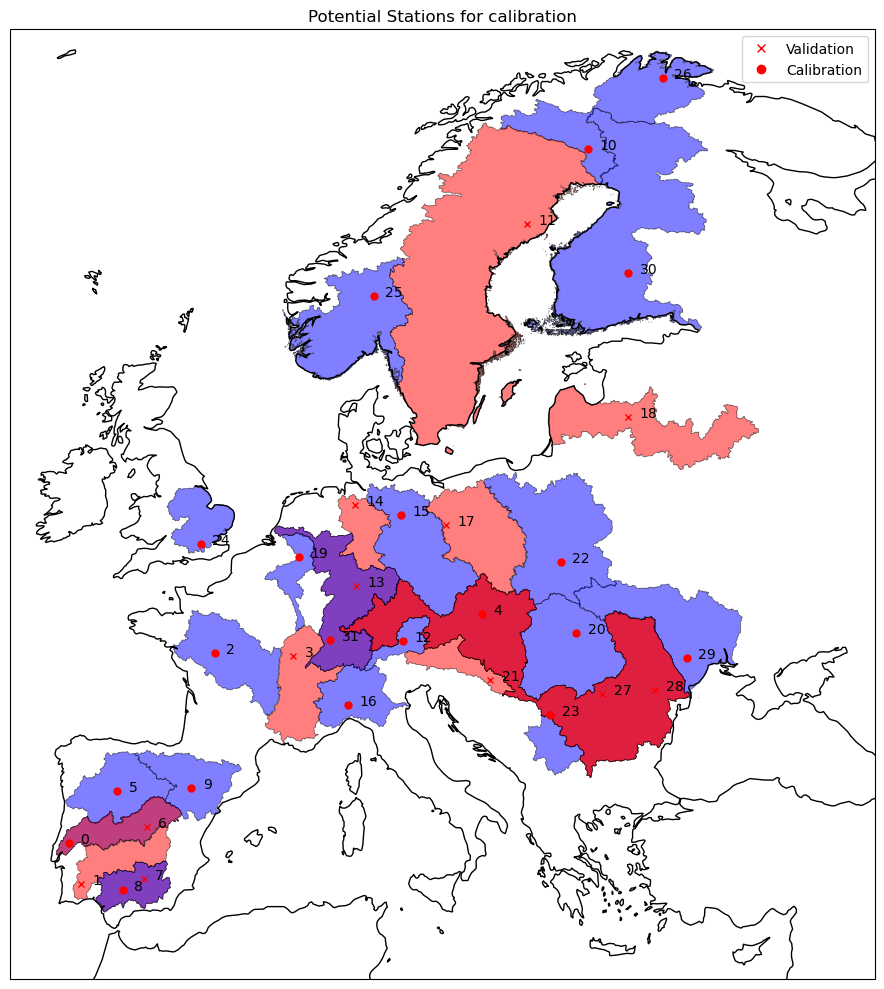

In [51]:
# Discharge maps in Cartopy
choosen_projection = ccrs.PlateCarree()   
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': choosen_projection})
#ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=1, linestyle='-')
validation_station = [1,6,3,14,13,27,18,11,28,17,7,21,27]
validation_sation_ID = [list_of_station_IDs[i] for i in validation_station]
# Punkt für Station hinzufügen
## fake point to fix the legend
ax.plot(0,0,'xr', label = 'Validation',transform=ccrs.PlateCarree())
ax.plot(0,0,'or', label = 'Calibration',transform=ccrs.PlateCarree())

for ID in list_of_station_IDs:
    i =list(list_of_station_IDs).index(ID)
    xr_obs_gauged_station.calibrated.loc[{'id': ID}] = 1-int(i in validation_station)
    color_cal = int(xr_obs_gauged_station.sel(id=ID).calibrated.values)*'r' + int(1-xr_obs_gauged_station.sel(id=ID).calibrated.values)*'r'
    mark = int(xr_obs_gauged_station.sel(id=ID).calibrated.values)*'o' + int(1-xr_obs_gauged_station.sel(id=ID).calibrated.values)*'x'
    if  xr_obs_gauged_station.calibrated.loc[{'id': ID}].values == 1:
        ax.plot(xr_obs_gauged_station.geo_x.sel(id=ID), xr_obs_gauged_station.geo_y.sel(id=ID),  'o' , color='r' , markersize=5, transform=ccrs.PlateCarree())
        color_map = 'b'
    else:
        ax.plot(xr_obs_gauged_station.geo_x.sel(id=ID), xr_obs_gauged_station.geo_y.sel(id=ID),  'x' , color='r' , markersize=5, transform=ccrs.PlateCarree())
        color_map ='r'

    ax.text(xr_obs_gauged_station.geo_x.sel(id=ID) + 0.7,  xr_obs_gauged_station.geo_y.sel(id=ID), i, horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=10)
    # gdf_id =  gdf.where(gdf.PFAF_ID == xr_obs_gauged_station.sel(id=ID).PFAF_ID.values).dropna()
    if regional == True:
        gdf_id =  gdf.where(gdf.OBJECTID == xr_obs_gauged_station.sel(id=ID).OBJECTID.values).dropna()
        gdf_id.plot(ax=ax, alpha=0.5,edgecolor="k",color=color_map, linewidth=0.5,transform=ccrs.PlateCarree())

# Visualiser la carte
# ax est l'objet AxesSubplot retourné par la méthode plot
# gdf.plot(ax=ax, alpha=0.5,edgecolor="k", linewidth=0.1,transform=ccrs.PlateCarree()) # Vous pouvez ajuster la valeur de linewidth selon vos besoins

ax.legend()

plt.title('Potential Stations for calibration') 
plt.tight_layout()

plt.show()
plt.close()

In [68]:
gdf_id = gdf.where(gdf.OBJECTID == xr_obs_gauged_station.sel(id=list_of_station_IDs[18
                                                             ]).OBJECTID.values).dropna()
# gdf_id.plot(alpha=0.5,edgecolor="k",color=color_map, linewidth=0.5,transform=ccrs.PlateCarree())

<Axes: >

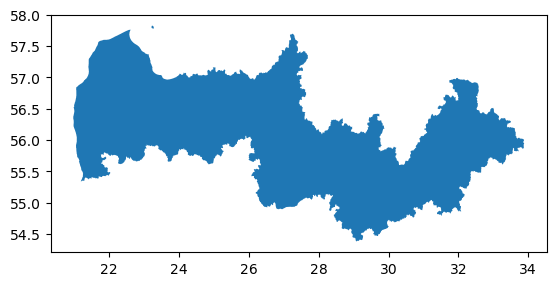

In [69]:
gdf_id.plot()

In [55]:
print(xr_obs_gauged_station.sel(id=list_of_station_IDs[29]).gauged_lon.values,xr_obs_gauged_station.sel(id=list_of_station_IDs[29]).geo_x.values,xr_obs_gauged_station.sel(id=list_of_station_IDs[29]).geo_y.values,xr_obs_gauged_station.sel(id=list_of_station_IDs[29]).gauged_lat.values)

29.4711 29.471111 46.830555 46.9139


In [74]:
xr_obs_gauged_station.sel(id=list_of_station_IDs[29])

<xarray.Dataset> Size: 734kB
Dimensions:              (time: 61072)
Coordinates:
  * time                 (time) datetime64[ns] 489kB 1857-01-01 ... 2024-03-17
    id                   int32 4B 6781800
Data variables: (12/14)
    runoff_mean          (time) float32 244kB ...
    area                 float32 4B ...
    country              <U2 8B ...
    geo_x                float32 4B ...
    geo_y                float32 4B ...
    geo_z                float32 4B ...
    ...                   ...
    station_name         <U32 128B ...
    timezone             float32 4B ...
    gauged_lat           float64 8B ...
    gauged_lon           float64 8B ...
    calibrated           float64 8B 1.0
    OBJECTID             int64 8B ...
Attributes:
    title:          Mean daily discharge (Q)
    Conventions:    CF-1.7
    references:     grdc.bafg.de
    institution:    GRDC
    history:        Download from GRDC Database, 27/05/2024
    missing_value:  -999.000

# 4. Writte the xarray into a nc file

In [64]:
writte = True 
if writte == True :
    xr_obs_gauged_station.to_netcdf('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')

# 5. Deap Calibration Analysing

## Analyse per calibration station


### functions

In [11]:
def KGE_per_Stations(obs,sim) : 
    observed_streamflow = obs.values.astype(np.float32)
    observed_streamflow[observed_streamflow<=-900]= np.nan
    sim[sim==1e31] = np.nan
    KGE_list = []
    
    stations= obs.id.values
    for stat_index in range(len(stations)) :
    #    print(stations.values[stat_index])
       # station = stations[stat_index]
        Qsim1=[] # Structure en ajout, peut etre plus long a run 
        q1 = sim[stat_index+1].values+0.0001
        observed_station_streamflow = observed_streamflow[:,stat_index] #Getting the data for the station stat index
        for i in range(observed_streamflow.shape[0]):
            if not(np.isnan(observed_station_streamflow[i])):
                Qsim1.append(q1[i])
        Qsim = np.asarray(Qsim1)
        Qobs = observed_station_streamflow[~np.isnan(observed_station_streamflow)]


        # Compute objective function score

        KGE_stat = hydroStats.KGE(s=Qsim,o=Qobs,warmup=WarmupDays)
        KGE_list.append(KGE_stat)
    return(KGE_list)

# KGE_list=KGE_per_Stations(streamflow_data,simulated_streamflow)

In [12]:
xr_obs_gauged_station = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')
stations_with_nan=list(xr_obs_gauged_station.id.where(xr_obs_gauged_station.calibrated==1).values)
stations = [x for x in stations_with_nan if not np.isnan(x)]
streamflow_data = xr_obs_gauged_station.runoff_mean.sel(id=stations).sel(time=slice(ForcingStart, ForcingEnd))


your_path = '/work/ch0636/g300128/Hydrologie_Calibration/Calibration/runs_calibration_net_cdf/'  # The directory where there are all the simulations
filename_discharge_criter = your_path + '/' + 'runs_log.csv'
folders_out = os.listdir(your_path)  # list of all folders containing simulated GW maps and settings file

folders = []
for ll in range(len(folders_out)):  # for each folder (=each simulation)

    if '09' not in folders_out[ll] and'best' not in folders_out[ll] and 'pkl' not in folders_out[ll] and 'front_history' not in folders_out[ll]\
            and 'pareto' not in folders_out[ll] and 'runs_log' not in folders_out[ll] and 'readme' not in folders_out[ll] and ".ipynb_checkpoints" not in folders_out[ll]  :
        folders.append(folders_out[ll])


# --------------------------------------------------------------------------
# Extract KGE criteria on discharge

In [37]:

dict_discharge_criter = {}  # Dictionary: {'simulation number': 'KGE value'}
with open(filename_discharge_criter, newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    cnt = 0
    for row in spamreader:
        dict_discharge_criter[row[0]] = row[1]
taille_run = len(folders)
taille_station = len(stations)
runs=[]
# Création d'un DataArray vide avec des dimensions 'run' et 'station'
KGE_data = xr.DataArray(np.empty((taille_run, taille_station)), dims=('run', 'station'))
# Définir les coordonnées
for ll in range(len(folders)):
        num_gen = int(folders[ll][:2])
        num_folder = ((num_gen-1)*16+100)*(num_gen!=0) + int(folders[ll][3:])
        runs.append(num_folder)
#stations = np.arange(taille_station)
# Ajout des coordonnées au DataArray
KGE_data = KGE_data.assign_coords(run=np.sort(runs), station=stations)
KGE_list =[-10]
#KGE_data = xr.DataArray(dims=('run', 'station'))
KGE_values = np.zeros(len(folders))  # KGE criteria for discharge
for ll in range(len(folders)):  # for each folder (=each simulation)
    if folders[ll] != ".ipynb_checkpoints":
        num_gen = int(folders[ll][:2])

        num_folder = ((num_gen-1)*16+100)*(num_gen!=0) + int(folders[ll][3:])
        simulated_streamflow=pandas.read_csv(your_path+folders[ll]+'/discharge_daily.tss',sep=r"\s+",index_col=0,skiprows=3+len(stations),header=None,skipinitialspace=True)
        KGE_list_run=KGE_per_Stations(streamflow_data,simulated_streamflow)
        if sum(KGE_list_run)>sum(KGE_list):
            KGE_list=KGE_list_run
            
        for i in range(len(KGE_list)):
            KGE_data.loc[{'run' : num_folder, 'station' : stations[i]}] = KGE_list[i]
            KGE_data.name='KGE'
# Sort the results in function of KGE to have the best models above

Ind = np.argsort(KGE_values)
folders_arranged = [folders[ind] for ind in Ind]


KeyboardInterrupt: 

# 6. Single Output Analysing

## 6.1 Analysing best run

In [14]:
stations_with_nan=list(xr_obs_gauged_station.id.where(xr_obs_gauged_station.calibrated==1).values)
stations = [x for x in stations_with_nan if not np.isnan(x)]
calib_obs = xr_obs_gauged_station.sel(id=stations)
streamflow_data = xr_obs_gauged_station.runoff_mean.sel(id=stations).sel(time=slice(ForcingStart, ForcingEnd))

n_station = len(stations)
#simulated_streamflow_best=pandas.read_csv(your_path+'streamflow_simulated_best.csv', sep=",", parse_dates=True, index_col=0, header=None)
simulated_streamflow_best=pandas.read_csv('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/vrac/discharge_daily.tss',sep=r"\s+",index_col=0,skiprows=3+n_station,header=None,skipinitialspace=True)
# simulated_streamflow_best=pandas.read_csv('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/bestrun_17_006/discharge_daily.tss',sep=r"\s+",index_col=0,skiprows=3+n_station,header=None,skipinitialspace=True)

best_kge_list = KGE_per_Stations(streamflow_data,simulated_streamflow_best)
KGE_data_best = xr.DataArray(np.empty((len(stations))), dims=('station'))
KGE_data_best = KGE_data_best.assign_coords(station=stations)

for i in range(len(best_kge_list)):
    KGE_data_best.loc[{'station' : stations[i]}] = best_kge_list[i]
    KGE_data_best.name='KGE_best'

/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/g/g300128/.local/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value enc

In [69]:
# simulated_streamflow_best=pandas.read_csv(your_path+'streamflow_simulated_best.csv', sep=",", parse_dates=True, index_col=0, header=None)
# best_kge_list = KGE_per_Stations(streamflow_data,simulated_streamflow_best)
# calib_obs = xr_obs_gauged_station.sel(id=stations)
# KGE_data_best = xr.DataArray(np.empty((len(stations),len(stations),len(stations))), dims=('geo_x','geo_y','station'))
# KGE_data_best = KGE_data_best.assign_coords(geo_x = calib_obs.geo_x.values, geo_y = calib_obs.geo_y.values, station=stations)
# for i in range(len(KGE_list)):
#     KGE_data_best.loc[{'station' : stations[i],'geo_x':calib_obs.isel(id=i).geo_x ,'geo_y':calib_obs.isel(id=i).geo_y}] = best_kge_list[i]
#     KGE_data_best.name='KGE_best'

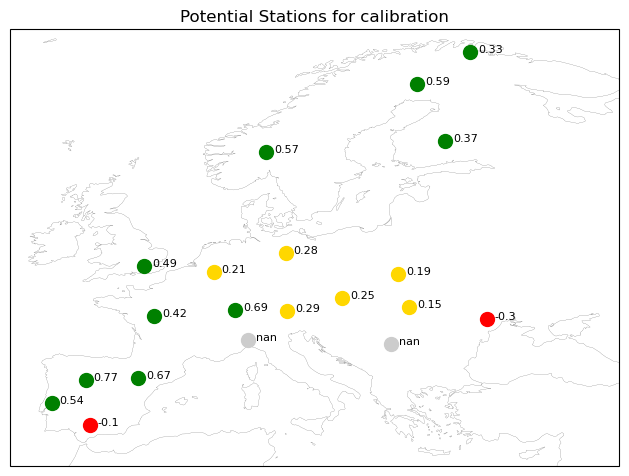

In [15]:
# Discharge maps in Cartopy
choosen_projection = ccrs.PlateCarree()   
ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=0.1, linestyle='-')
# Punkt für Station hinzufügen
for ID in stations:
    KGE =KGE_data_best.sel(station=ID).values
    if KGE >= 0.3 :
        color_KGE = 'g'
    if KGE >= 0 and KGE < 0.3 :
        color_KGE = '#FFD700' 
    if KGE < 0 :
        color_KGE = 'r'
    if np.isnan(KGE):
        color_KGE = (0.8, 0.8, 0.8)
    ax.plot(calib_obs.geo_x.sel(id=ID), calib_obs.geo_y.sel(id=ID), 'o', color = color_KGE , markersize=10, transform=ccrs.PlateCarree())
    
# # Textbeschriftung hinzufügen
for ID in stations:
    KGE =KGE_data_best.sel(station=ID).values
    ax.text(calib_obs.geo_x.sel(id=ID)+ 0.7,  calib_obs.geo_y.sel(id=ID), np.round(KGE,2), horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=8)

plt.title('Potential Stations for calibration') 
plt.tight_layout()
# plt.savefig(file_save_graph + '/' + 'map_of_stations_automatically' + '_' + area + '_' + yearsname + '.jpg')
plt.show()
plt.close()


## 6.2 Calibration and Validation (considering the best run)

In [6]:
begin = '01/01/1988' 
end = '31/12/2008'
A_lon, A_lat, B_lon, B_lat = -12 , 34 , 41 , 72
ForcingStart = datetime.datetime.strptime(begin,"%d/%m/%Y")  # Start of forcing
ForcingEnd = datetime.datetime.strptime(end,"%d/%m/%Y")

xr_obs_gauged_station  = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/GRDC-Daily-allEurope_Gauged_calibrated.nc')

simulated_streamflow_best_xr= xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/best_run_calibration_validation_12_07/discharge_daily.nc')

Get the discharge for each stations  /!\ Quite long step 

In [7]:
L=[]
for ID in xr_obs_gauged_station.id.values:
    simulated_streamflow_best_stat = simulated_streamflow_best_xr.sel(time=slice(ForcingStart, ForcingEnd)).sel(lat = xr_obs_gauged_station.sel(id=ID).gauged_lat, method='nearest').sel(lon = xr_obs_gauged_station.sel(id=ID).gauged_lon, method='nearest')
    L.append(simulated_streamflow_best_stat.discharge.values)
Lt = np.array(L).transpose()
simulated_streamflow_best = pd.DataFrame(Lt,columns=range(1,33))

KeyboardInterrupt: 

In [ ]:
# temoins_simulated_streamflow= simulated_streamflow_best
calibrated_simulated_streamflow= simulated_streamflow_best

Easy to use data frame

In [ ]:
KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data.nc')


In [ ]:
KGE_data_best.KGE_best.values

In [ ]:
# calib_obs = xr_obs_gauged_station.sel(id=stations)
stations= xr_obs_gauged_station.id.values
# simulated_streamflow = calibrated_simulated_streamflow
# simulated_streamflow[simulated_streamflow==1e31] = np.nan # before was simulated_streamflow[i]
# best_kge_list = KGE_per_Stations(xr_obs_gauged_station.sel(time=slice(ForcingStart, ForcingEnd)).runoff_mean,simulated_streamflow)
best_kge_list = KGE_data_best.KGE_best.values
KGE_data_best = xr.DataArray(np.empty((len(stations))), dims=('station'))
KGE_data_best = KGE_data_best.assign_coords(station=stations)
KGE_calibration = xr.DataArray(np.empty((len(stations))), dims=('station'))
KGE_calibration = KGE_calibration.assign_coords(station=stations)
for i in range(len(best_kge_list)):
    KGE_data_best.loc[{'station' : stations[i]}] = best_kge_list[i]
    KGE_calibration.loc[{'station' : stations[i]}] = xr_obs_gauged_station.sel(id = stations[i]).calibrated.values
KGE_data_best.name='KGE_best'
KGE_calibration.name='calibrated'
KGE_data_best=xr.merge([KGE_data_best,KGE_calibration])

In [ ]:
KGE_data_best.to_netcdf('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data_wth_calib.nc')

Plot with Colors

In [ ]:
# Discharge maps in Cartopy
# .KGE_best
KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data_wth_calib.nc')
# KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/best_run_calibration_validation_12_07/KGE_data_wth_calib.nc')

choosen_projection = ccrs.PlateCarree()   
ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=0.1, linestyle='-')
ax.plot(0,0,'xg', label = 'Validation',transform=ccrs.PlateCarree())
ax.plot(0,0,'og', label = 'Calibration',transform=ccrs.PlateCarree())
# Punkt für Station hinzufügen
for ID in stations:
    KGE =KGE_data_best.KGE_best.sel(station=ID).values
    if KGE >= 0.3 :
        color_KGE = 'g'
    if KGE >= 0 and KGE < 0.3 :
        color_KGE = '#FFD700' 
    if KGE < 0 :
        color_KGE = 'r'
    if np.isnan(KGE):
        color_KGE = (0.8, 0.8, 0.8)
    if xr_obs_gauged_station.sel(id = ID).calibrated == 1 :
        mark = 'o'
    else :
        mark = 'x'
    # mark = 'o'
    ax.plot(xr_obs_gauged_station.geo_x.sel(id=ID), xr_obs_gauged_station.geo_y.sel(id=ID), mark, color = color_KGE , markersize=10, transform=ccrs.PlateCarree())
    
# # Textbeschriftung hinzufügen
for ID in stations:
    KGE =KGE_data_best.KGE_best.sel(station=ID).values
    # ax.text(xr_obs_gauged_station.geo_x.sel(id=ID)+ 0.7,  xr_obs_gauged_station.geo_y.sel(id=ID), np.round(KGE,2), horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=8)
    ax.text(xr_obs_gauged_station.geo_x.sel(id=ID)+ 0.7,  xr_obs_gauged_station.geo_y.sel(id=ID),'??', horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=8)
ax.legend()
ax.legend()
plt.title('KGE for each calibration stations- Default CWatM-1988-2008') 
plt.tight_layout()
# plt.savefig(file_save_graph + '/' + 'map_of_stations_automatically' + '_' + area + '_' + yearsname + '.jpg')
plt.show()
plt.close()
print('1 .Mean Mean 2 .Calibrated  3 .Mean uncalibrated :', KGE_data_best.KGE_best.mean('station').values, 
      KGE_data_best.KGE_best.where(KGE_data_best.calibrated==1).mean('station').values
     ,KGE_data_best.KGE_best.where(KGE_data_best.calibrated==0).mean('station').values)
print('1 .std std 2 .Calibrated  3 .std uncalibrated :', KGE_data_best.KGE_best.std('station').values, 
      KGE_data_best.KGE_best.where(KGE_data_best.calibrated==1).std('station').values
     ,KGE_data_best.KGE_best.where(KGE_data_best.calibrated==0).std('station').values)
# print(KGE_data_best.std('station'))

In [ ]:
# .KGE_best
# KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data_wth_calib.nc')
KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/best_run_calibration_validation_12_07/KGE_data_wth_calib.nc')

choosen_projection = ccrs.PlateCarree()   
ax = plt.axes(projection = choosen_projection) 
ax.set_extent([A_lon, B_lon, A_lat, B_lat], crs = choosen_projection)
ax.coastlines(linewidth=0.1, linestyle='-')
ax.plot(0,0,'xg', label = 'Validation',transform=ccrs.PlateCarree())
ax.plot(0,0,'og', label = 'Calibration',transform=ccrs.PlateCarree())
# Punkt für Station hinzufügen
for ID in stations:
    KGE =KGE_data_best.KGE_best.sel(station=ID).values
    if KGE >= 0.3 :
        color_KGE = 'g'
    if KGE >= 0 and KGE < 0.3 :
        color_KGE = '#FFD700' 
    if KGE < 0 :
        color_KGE = 'r'
    if np.isnan(KGE):
        color_KGE = (0.8, 0.8, 0.8)
    if xr_obs_gauged_station.sel(id = ID).calibrated == 1 :
        mark = 'o'
    else :
        mark = 'x'
    # mark = 'o'
    ax.plot(xr_obs_gauged_station.geo_x.sel(id=ID), xr_obs_gauged_station.geo_y.sel(id=ID), mark, color = color_KGE , markersize=10, transform=ccrs.PlateCarree())
    
# # Textbeschriftung hinzufügen
for ID in stations:
    KGE =KGE_data_best.KGE_best.sel(station=ID).values
    # ax.text(xr_obs_gauged_station.geo_x.sel(id=ID)+ 0.7,  xr_obs_gauged_station.geo_y.sel(id=ID), np.round(KGE,2), horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=8)
    ax.text(xr_obs_gauged_station.geo_x.sel(id=ID)+ 0.7,  xr_obs_gauged_station.geo_y.sel(id=ID),'??', horizontalalignment='left', transform=ccrs.PlateCarree(), fontsize=8)

ax.legend()
plt.title('KGE for each calibration stations-CWatM-1988-2008') 
plt.tight_layout()
# plt.savefig(file_save_graph + '/' + 'map_of_stations_automatically' + '_' + area + '_' + yearsname + '.jpg')
plt.show()
plt.close()
print('1 .Mean Mean 2 .Calibrated  3 .Mean uncalibrated :', KGE_data_best.KGE_best.mean('station').values, 
      KGE_data_best.KGE_best.where(KGE_data_best.calibrated==1).mean('station').values
     ,KGE_data_best.KGE_best.where(KGE_data_best.calibrated==0).mean('station').values)

print('1 .std std 2 .Calibrated  3 .std uncalibrated :', KGE_data_best.KGE_best.std('station').values, 
      KGE_data_best.KGE_best.where(KGE_data_best.calibrated==1).std('station').values
     ,KGE_data_best.KGE_best.where(KGE_data_best.calibrated==0).std('station').values)
# print(KGE_data_best.std('station'))

In [ ]:
# df = xr_obs_gauged_station.drop_vars('runoff_mean').isel(time=0).to_dataframe()
# df.to_excel('/work/ch0636/g300128/Hydrologie_Calibration/Scripts/Notebooks/GRDC_gauged_stations.xlsx')

In [ ]:
KGE_data_best

Text(0, 0.5, 'KGE')

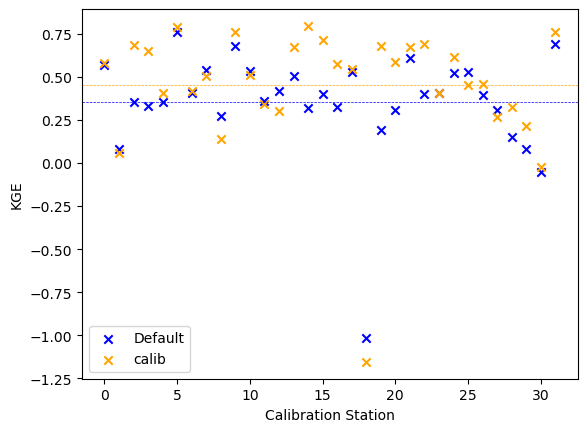

In [9]:
KGE_data_best_calib= xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/best_run_calibration_validation_12_07/KGE_data_wth_calib.nc')
KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data_wth_calib.nc')

plt.scatter(range(len(KGE_data_best.KGE_best.values)),KGE_data_best.KGE_best,label='Default',marker='x',color='b')
plt.scatter(range(len(KGE_data_best.KGE_best.values)),KGE_data_best_calib.KGE_best,label='calib',marker='x',color='orange')
# Ajouter une ligne verticale
plt.axhline(KGE_data_best.KGE_best.mean(), color='b', linestyle='dashed', linewidth=0.5)
plt.axhline(KGE_data_best_calib.KGE_best.mean(), color='orange', linestyle='dashed', linewidth=0.5)
plt.legend()
plt.xlabel('Calibration Station')
plt.ylabel('KGE')

In [47]:
KGE_data_best.values

<bound method Mapping.values of <xarray.Dataset> Size: 384B
Dimensions:   (station: 32)
Coordinates:
  * station   (station) int32 128B 6113050 6116200 6123400 ... 6854250 6935051
Data variables:
    KGE_best  (station) float64 256B ...>

In [52]:
KGE_data_best = xr.open_dataset('/work/ch0636/g300128/Hydrologie_Calibration/data/output-files/Temoins/KGE_data.nc')

In [68]:
KGE_data_best

<xarray.Dataset> Size: 640B
Dimensions:     (station: 32)
Coordinates:
  * station     (station) int32 128B 6113050 6116200 6123400 ... 6854250 6935051
Data variables:
    KGE_best    (station) float64 256B 0.5776 0.06011 0.6847 ... -0.02345 0.7597
    calibrated  (station) float64 256B 1.0 0.0 1.0 0.0 1.0 ... 0.0 1.0 1.0 1.0